# IMPORTS

In [1]:
# Imports
import cv2
import os
import tensorflow
import math
import pywt

import keras
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import glob
import pickle
# from skimage.feature import
from scipy.interpolate import interp1d

In [2]:
def process_hough(imagepath, image, radius):
    try:
        print("Processing image:", imagepath)

        # Resize the image to a fixed size
        print("Original image size:", image.shape)
        image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
        print("Resized image size:", image.shape)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply median blur to reduce noise
        gray = cv2.medianBlur(gray, 11)

        # Detect edges using Canny edge detector
        edge = cv2.Canny(gray, 100, 200)

        # Apply Otsu's thresholding to get a binary image
        ret, binary_image = cv2.threshold(
            gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find circles in the binary image using Hough Circle Transform
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 50,
                                   param1=ret, param2=30, minRadius=20, maxRadius=100)

        # If circles are found
        if circles is not None:
            circles = np.uint16(np.around(circles))
            success = True

            for circle in circles[0, :]:
                # Extract region of interest around each detected circle
                x, y, r = circle
                x = int(x)
                y = int(y)
                r = int(r)
                roi = image[y - r - radius: y + r +
                            radius, x - r - radius: x + r + radius]
                radius = r

            return roi, radius, success

        else:
            # If no circles are found, set the whole image to white
            image[:] = 255
            print(f"{imagepath} -> No circles (iris) found.")
            success = False
            cv2.imshow("Image", image)
            # Wait for a key press (blocks execution)
            # cv2.waitKey(0)

            # Modify the return statement to ensure a tuple with three elements is always returned
            return image, None, success

    except Exception as e:
        print("Error:", e)
        return None, None, False

In [3]:
def remove_reflection(image):
    try:
        # Threshold the image to create a mask of the reflection
        ret, mask = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

        # Apply dilation to the mask to fill in gaps in the reflection
        kernel = np.ones((5, 5), np.uint8)
        dilation = cv2.dilate(mask, kernel, iterations=1)

        # Use inpainting to remove the reflection based on the dilation
        image_rr = cv2.inpaint(image, dilation, 5, cv2.INPAINT_TELEA)

        return image_rr

    except Exception as e:
        print("Error:", e)
        return None

In [4]:
def generate_rubber_sheet_model(image):
    try:
        q = np.arange(0.00, np.pi * 2, 0.01)
        inn = np.arange(0, int(image.shape[0] / 2), 1)

        cartisian_image = np.empty(shape=[inn.size, int(image.shape[1]), 3])
        m = interp1d([np.pi * 2, 0], [0, image.shape[1]])

        for r in inn:
            for t in q:
                polarX = int((r * np.cos(t)) + image.shape[1] / 2)
                polarY = int((r * np.sin(t)) + image.shape[0] / 2)
                try:
                    cartisian_image[int(r)][int(m(t))] = image[polarY][polarX]
                except Exception as e:
                    print("Error:", e)

        return cartisian_image.astype("uint8")

    except Exception as e:
        print("Error:", e)
        return None

In [5]:
def parse_iris_dataset(keep_reflections):
    try:
        eye_images = []

        base_directory = 'Dataset/VISA_Iris/VISA_Iris'

        for path in glob.iglob(base_directory + '/*'):
            foldername = os.path.basename(path)
            label = foldername
            print('label: ' + label)
            image_id = 1

            # Process Left Eye
            for image_path in glob.iglob(path + '/L/*'):
                eye = '-left'
                image = cv2.imread(image_path)

                image_hough_processed = process_hough(
                    image_path, image, 50)  # hough transform

                if (keep_reflections):
                    image_hough_processed = remove_reflection(
                        image_hough_processed)

                if image_hough_processed is not None:
                    (testimage, x, success) = image_hough_processed
                    if success:
                        # Append the left eye image and its metadata
                        eye_images.append([testimage, image_id, label])
                        image_id += 1
                else:
                    print(f"Error processing image: {image_path}")

            print('L eye: ' + str(image_id - 1))

            image_id = 1
            # Process Right Eye
            for image_path in glob.iglob(path + '/R/*'):
                eye = '-right'
                image = cv2.imread(image_path)

                image_hough_processed = process_hough(
                    image_path, image, 50)  # hough transform

                if (keep_reflections):
                    image_hough_processed = remove_reflection(
                        image_hough_processed)

                if image_hough_processed is not None:
                    (testimage, x, success) = image_hough_processed
                    if success:
                        # Append the right eye image and its metadata
                        eye_images.append([testimage, image_id, label + eye])
                        image_id += 1
                else:
                    print(f"Error processing image: {image_path}")

            print('R iris: ' + str(image_id - 1))

        print('Iris images: ' + str(len(eye_images)))

        return eye_images

    except Exception as e:
        print("Error:", e)
        return None

In [6]:
def process_images(eye_images):
    try:
        # Create a directory for saving the processed images if it doesn't exist
        output_dir = "Iris_Output_Demo"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for eye_image in eye_images:
            (hough_information, image_id, label) = eye_image
            (image, radius, success) = hough_information
            print(str(image_id) + ': ' + str(success))
            if success and image.size > 0:
                image_daugman = generate_rubber_sheet_model(image)
                if image_daugman is not None:
                    # Create a directory for the label if it doesn't exist
                    label_dir = os.path.join(output_dir, label)
                    if not os.path.exists(label_dir):
                        os.makedirs(label_dir)

                    # Save the processed image into the respective label directory
                    cv2.imwrite(
                        os.path.join(label_dir, f'{image_id}.Iris.bmp'),
                        image_daugman
                    )
                else:
                    print(
                        f"Failed to generate Daugman for image: {label}.{image_id}")
            else:
                print(f"Failed to process image: {label}.{image_id}")
    except Exception as e:
        print("Error:", e)

In [7]:
keep_reflections = False
eye_images = parse_iris_dataset(keep_reflections)
stuff = process_images(eye_images)

label: S0001_F_30
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\1.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\10.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\11.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\12.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\13.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\14.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\15.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VI

In [8]:
# OBSOLETE - Detect Iris using Iris Cascade
def detect_iris(eye_images, display):
    eye_num_2 = 0
    eyes_num = 0
    # explain how this works in presentation
    eye_cascade = cv2.CascadeClassifier('haarcascade_iris.xml')
    for eye_image in eye_images:
        (image, image_id, label) = eye_image
        image_id += 1
        eyes = eye_cascade.detectMultiScale(image, 1.1, 0)

        if len(eyes) > 1:  # idk what is happening
            eyes_num = eyes_num + 1
            maxium_area = -3

        for (x, y, width, height) in eyes:
            area = width * height

            if area > maxium_area:
                maxium_area = area
                maxium_width = width
                point_x = x
                point_y = y
                maxium_height = height

        image_unboxed = image.copy()

        image_cropped = image_unboxed[point_y:point_y + maxium_height,
                                      point_x:point_x + maxium_width,]

        image_boxed = cv2.rectangle(
            image,
            (point_x, point_y),
            (point_x + maxium_width, point_y + maxium_height),
            (255, 0, 0),
            2,
        )

        cv2.imwrite(
            'Processed/'+str(label) + '.' + str(image_id) + '.Iris' + '.bmp',
            image_cropped
        )

    print("iris image preprocessing done")

    if (display):
        fig, axes = plot.subplots(1, 3, figsize=(12, 5))

        axes[0].imshow(image_unboxed)
        axes[0].set_title('Original Image')
        axes[0].axis('off')  # Hide axes for cleaner presentation

        axes[1].imshow(image_boxed)
        axes[1].set_title('Iris Detection')
        axes[1].axis('off')

        axes[2].imshow(image_cropped)
        axes[2].set_title('Cropped Image')
        axes[2].axis('off')

        plot.tight_layout()
        plot.show()

    print("total_eyes_found = ", eyes_num)
    print("total_eyes_found 2 = ", eye_num_2)
    print("total images: ", len(eye_images))


eye_images = parse_iris_dataset(keep_reflections=False)
process_images(eye_images)

label: S0001_F_30
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\1.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\10.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\11.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\12.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\13.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\14.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VISA_Iris\S0001_F_30/L\15.bmp
Original image size: (480, 640, 3)
Resized image size: (480, 640, 3)
Processing image: Dataset/VISA_Iris/VI

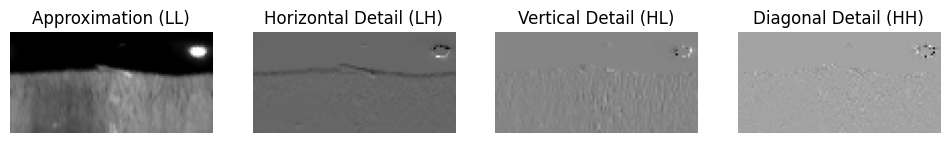

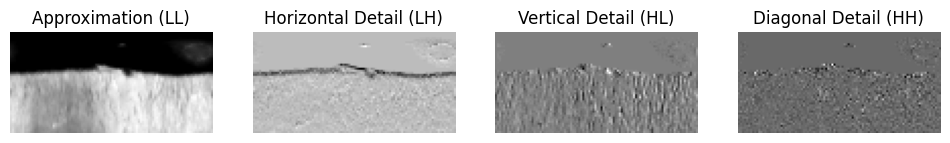

DWT Features: [142.8739, 116.8735690769731, 510.00000000000006, 0.0, 181.00000000000003, -1.0781, 8.421980194111123, 195.00000000000003, -129.5, 0.0, 0.11709999999999982, 7.677690902217933, 162.0, -175.50000000000006, 0.0, -0.07690000000000002, 3.6653971667474186, 53.00000000000001, -93.5, 0.0]
DWT Features N: [137.5854, 112.25012742460474, 298.00000000000006, 0.0, 179.00000000000003, -1.0806, 5.615487836332656, 19.000000000000004, -53.00000000000001, 0.0, -0.016200000000000173, 5.526910308662519, 39.50000000000001, -39.0, 0.0, -0.005400000000000023, 2.1646641402305353, 23.000000000000007, -16.000000000000004, 0.0]


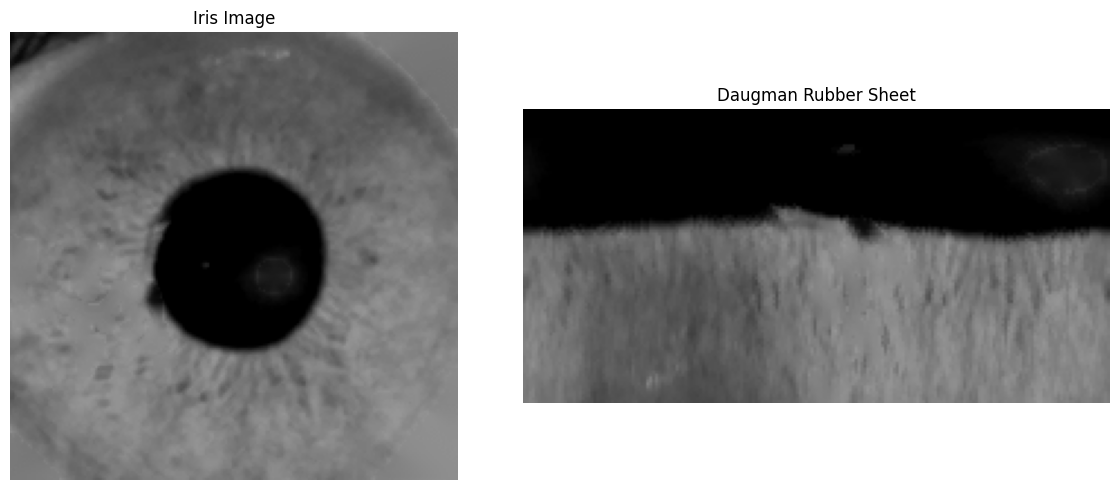

In [9]:
# For Display

def processing(image_path, r):
    success = False
    image = cv2.imread(image_path)
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 11)
    ret, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )
    try:
        circles = circles[0, :, :]
        circles = np.int16(np.array(circles))
        for i in circles[:]:
            image = image[
                i[1] - i[2] - r: i[1] + i[2] + r, i[0] - i[2] - r: i[0] + i[2] + r
            ]
            radius = i[2]
        success = True
        return image, radius, success
    except:
        image[:] = 255
        print(f"{image_path} -> No circles (iris) found.")
        success = False
        return image, image.shape[0], success


def generate_rubber_sheet_model(img):
    q = np.arange(0.00, np.pi * 2, 0.01)
    inn = np.arange(0, int(img.shape[0] / 2), 1)

    cartisian_image = np.empty(shape=[inn.size, int(img.shape[1]), 3])
    m = interp1d([np.pi * 2, 0], [0, img.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + img.shape[1] / 2)
            polarY = int((r * np.sin(t)) + img.shape[0] / 2)
            try:
                cartisian_image[int(r)][int(m(t))] = img[polarY][polarX]
            except:
                pass

    return cartisian_image.astype("uint8")


def remove_reflection(img):
    ret, mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    # Convert mask to 8-bit, 1-channel image
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    dst = cv2.inpaint(img, dilation, 5, cv2.INPAINT_TELEA)
    return dst


def feature_extraction(img):
    features = []
    ccoeffs = pywt.dwt2(img[:, :, 0], 'haar')
    LL, (LH, HL, HH) = ccoeffs
    for coef in [LL, LH, HL, HH]:
        features.append(np.mean(coef))
        features.append(np.std(coef))
        features.append(np.max(coef))
        features.append(np.min(coef))
        features.append(np.median(coef))

    titles = ['Approximation (LL)', 'Horizontal Detail (LH)',
              'Vertical Detail (HL)', 'Diagonal Detail (HH)']
    images = [LL, LH, HL, HH]
    # Plot all DWT coefficients horizontally in a single graph
    plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

    for i, (title, image) in enumerate(zip(titles, images), 1):
        plt.subplot(1, 4, i)  # Arrange subplots in a single row
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

    return features


imagepath = "Dataset/VISA_Iris/VISA_Iris/S0001_F_30/R/1.bmp"

# hough
image1, radius, success = processing(imagepath, 60)

# remove reflection
imageN = remove_reflection(image1)

# daugman
sheet = generate_rubber_sheet_model(image1)
sheetN = generate_rubber_sheet_model(imageN)

# dwt reflection
dwt_feature = feature_extraction(sheet)

# dwt no reflection
dwt_featureN = feature_extraction(sheetN)

print("DWT Features:", dwt_feature)
print("DWT Features N:", dwt_featureN)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(imageN)
axes[0].set_title('Iris Image')
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow(sheetN)
axes[1].set_title('Daugman Rubber Sheet')
axes[1].axis('off')

plt.tight_layout()
plt.show()

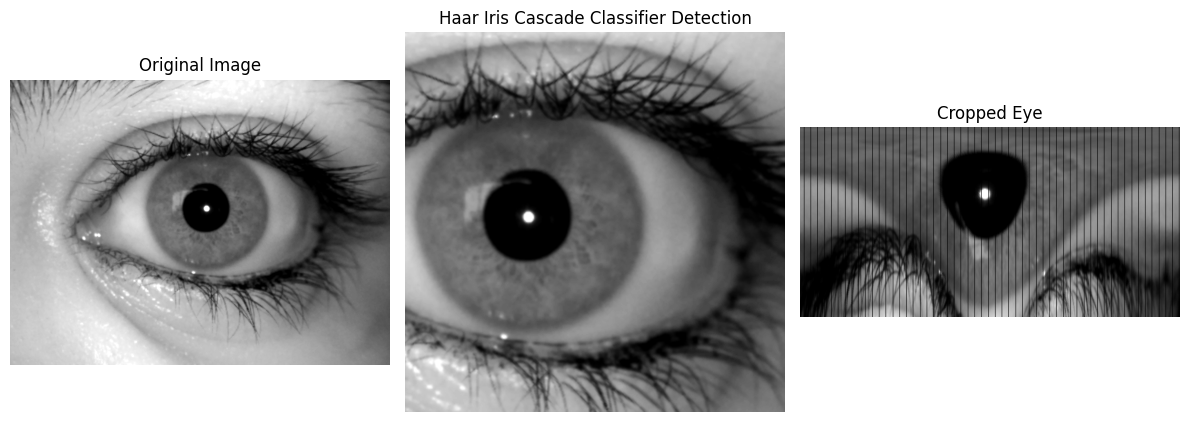

In [10]:
# test

imagepath = "Dataset/VISA_Iris/VISA_Iris/S0001_F_30/L/2.bmp"

eye_image = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)

eye_circles = cv2.HoughCircles(
    eye_image, cv2.HOUGH_GRADIENT, 2, 100,  minRadius=90, maxRadius=200)

iris_coordinates = None

if eye_circles is not None:
    circle = eye_circles[0][0]
    iris_coordinates = (circle[0], circle[1])

if iris_coordinates is not None:
    x = int(iris_coordinates[0])
    y = int(iris_coordinates[1])

    w = int(round(circle[2]) + 10)
    h = int(round(circle[2]) + 10)

    image_hough_processed = eye_image[y-h:y+h, x-w:x+w]
    iris_image_to_show = cv2.resize(
        image_hough_processed, (image_hough_processed.shape[1]*2, image_hough_processed.shape[0]*2))

q = np.arange(0.00, np.pi*2, 0.01)  # theta
inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1)  # radius

cartisian_image = np.empty(
    shape=[inn.size, int(iris_image_to_show.shape[1]), 3])
m = interp1d([np.pi*2, 0], [0, iris_image_to_show.shape[1]])

for r in inn:
    for t in q:
        polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
        polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
        cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

cartisian_image = cartisian_image.astype('uint8')

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].imshow(eye_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(iris_image_to_show, cmap='gray')
axes[1].set_title('Haar Iris Cascade Classifier Detection')
axes[1].axis('off')

axes[2].imshow(cartisian_image, cmap='gray')
axes[2].set_title('Cropped Eye')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# PARSE IRIS DATASET

In [11]:
def parse_iris_dataset():
    eye_images = []
    base_directory = 'Dataset/VISA_Iris/VISA_Iris'

    for path in glob.iglob(base_directory + '/*'):
        foldername = os.path.basename(path)
        label = foldername
        print('Label:', label)
        image_id = 0

        # Process Left Eye
        for image_path in glob.iglob(path + '/L/*'):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (400, 300))
            eye_images.append([image, image_id, label])  # Left iris
            image_id += 1

        print('Left eye count:', image_id)

        # Process Right Eye
        for image_path in glob.iglob(path + '/R/*'):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (400, 300))
            eye_images.append(
                [image, image_id, label + '-right'])  # Right iris
            image_id += 1

        print('Right eye count:', image_id)

    print('Total iris images:', len(eye_images))
    return eye_images

# IRIS DETECTION

Label: S0001_F_30
Left eye count: 19
Right eye count: 45
Label: S0002_M_24
Left eye count: 14
Right eye count: 34
Label: S0003_M_32
Left eye count: 10
Right eye count: 20
Label: S0004_M_16
Left eye count: 25
Right eye count: 51
Label: S0005_M_11
Left eye count: 10
Right eye count: 30
Label: S0006_F_10
Left eye count: 12
Right eye count: 28
Label: S0007_F_23
Left eye count: 10
Right eye count: 31
Label: S0008_F_25
Left eye count: 10
Right eye count: 35
Label: S0009_M_22
Left eye count: 28
Right eye count: 58
Label: S0010_M_24
Left eye count: 18
Right eye count: 38
Label: S0011_M_23
Left eye count: 11
Right eye count: 28
Label: S0012_M_54
Left eye count: 24
Right eye count: 46
Label: S0013_M_34
Left eye count: 10
Right eye count: 20
Label: S0014_M_54
Left eye count: 19
Right eye count: 41
Label: S0015_M_26
Left eye count: 24
Right eye count: 53
Label: S0016_M_34
Left eye count: 11
Right eye count: 22
Label: S0017_F_60
Left eye count: 20
Right eye count: 51
Label: S0018_F_43
Left eye coun

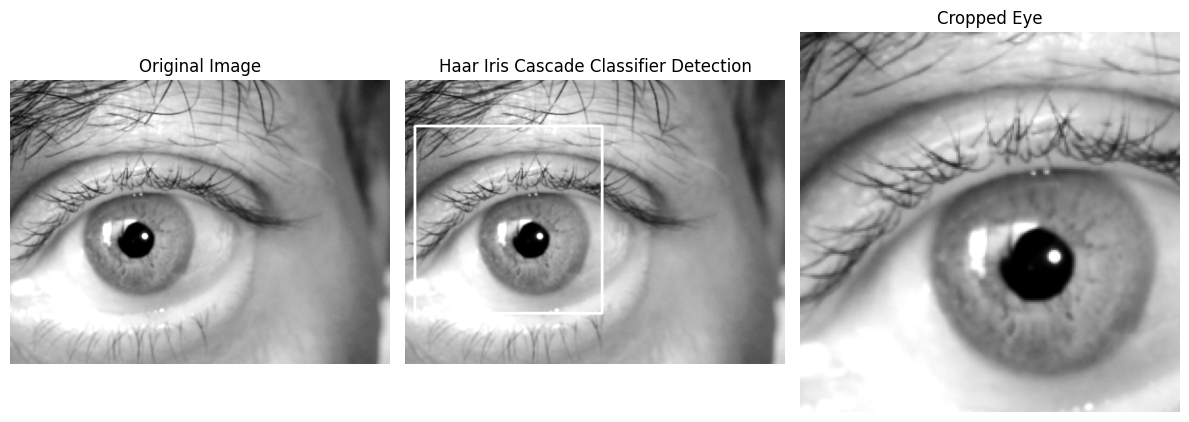

Total eyes found: 1798
Total images: 1798


In [12]:
def iris_detection(eye_images, display):
    eye_num_2 = 0
    eyes_num = 0

    # Load the Haar cascade classifier for eye detection
    eye_cascade = cv2.CascadeClassifier('Dependencies/haarcascade_eye.xml')

    for eye_image in eye_images:
        (image, image_id, label) = eye_image
        image_id += 1
        eyes = eye_cascade.detectMultiScale(image, 1.1, 0)

        if len(eyes) > 1:
            eyes_num += 1
            max_area = -3

        for (x, y, width, height) in eyes:
            area = width * height

            if area > max_area:
                max_area = area
                max_width = width
                point_x = x
                point_y = y
                max_height = height

        image_unboxed = image.copy()

        image_cropped = image_unboxed[point_y:point_y + max_height,
                                      point_x:point_x + max_width]

        image_boxed = cv2.rectangle(
            image,
            (point_x, point_y),
            (point_x + max_width, point_y + max_height),
            (255, 0, 0),
            2,
        )

        cv2.imwrite(
            f'Processed/{label}.{image_id}.Iris.bmp',
            image_cropped
        )

    if display:
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        axes[0].imshow(image_unboxed, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(image_boxed, cmap='gray')
        axes[1].set_title('Haar Iris Cascade Classifier Detection')
        axes[1].axis('off')

        axes[2].imshow(image_cropped, cmap='gray')
        axes[2].set_title('Cropped Eye')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    print("Total eyes found:", eyes_num)
    print("Total images:", len(eye_images))


# Parse the iris dataset to get the list of eye images
eye_images = parse_iris_dataset()

# Call the iris_detection function to detect irises in the eye images and display the results
iris_detection(eye_images, display=True)

# MAIN

Label: S0001_F_30
Left eye count: 19
Right eye count: 45
Label: S0002_M_24
Left eye count: 14
Right eye count: 34
Label: S0003_M_32
Left eye count: 10
Right eye count: 20
Label: S0004_M_16
Left eye count: 25
Right eye count: 51
Label: S0005_M_11
Left eye count: 10
Right eye count: 30
Label: S0006_F_10
Left eye count: 12
Right eye count: 28
Label: S0007_F_23
Left eye count: 10
Right eye count: 31
Label: S0008_F_25
Left eye count: 10
Right eye count: 35
Label: S0009_M_22
Left eye count: 28
Right eye count: 58
Label: S0010_M_24
Left eye count: 18
Right eye count: 38
Label: S0011_M_23
Left eye count: 11
Right eye count: 28
Label: S0012_M_54
Left eye count: 24
Right eye count: 46
Label: S0013_M_34
Left eye count: 10
Right eye count: 20
Label: S0014_M_54
Left eye count: 19
Right eye count: 41
Label: S0015_M_26
Left eye count: 24
Right eye count: 53
Label: S0016_M_34
Left eye count: 11
Right eye count: 22
Label: S0017_F_60
Left eye count: 20
Right eye count: 51
Label: S0018_F_43
Left eye coun

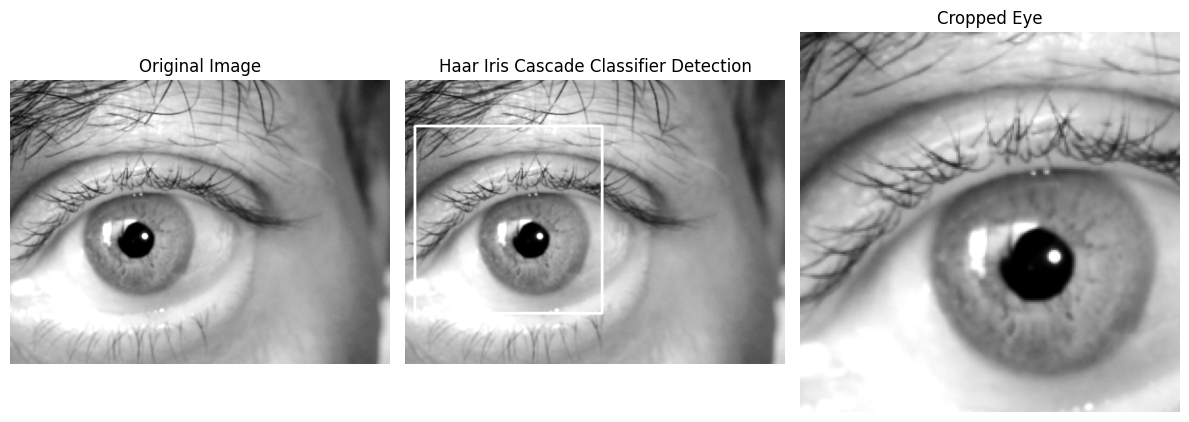

Total eyes found: 1798
Total images: 1798


: 

In [13]:

# Parse the iris dataset to get the list of eye images
eye_images = parse_iris_dataset()

# Call the iris_detection function to detect irises in the eye images and display the results
iris_detection(eye_images, display=1)